# CSCI316 Assignment 1 Task 2
- Name: Nguyen Gia Khanh
- UOWID: 7311217

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

### Read data

In [3]:
df1 = pd.read_csv("customer_churn_dataset-training-master.csv")
df2 = pd.read_csv("customer_churn_dataset-testing-master.csv")
df = pd.concat([df1, df2], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 505207 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 50.1+ MB


### Clean data

Remove missing value

In [4]:
df = df.dropna()

Data binning

In [5]:
# Total spend binning
column_to_bin = 'Total Spend'
bin_labels = [1, 2, 3, 4, 5]
# Gender binning
gender = {'Male' : 0, 'Female' : 1}
# Subscription Type binning
sub_type = {'Standard' : 0, 'Basic' : 1, 'Premium' : 2}
# Contract Length binning
cont_len = {'Annual' : 0, 'Monthly' : 1, 'Quarterly' : 2}
# Total spend
df['Total Spend Binned'] = pd.cut(df[column_to_bin], bins=5, labels=bin_labels)
df.insert(loc=9, column = "Total Spend Bin", value = df['Total Spend Binned'])
# Gender
df['Gender'] = df['Gender'].map(gender)
# Sub type
df['Subscription Type'] = df['Subscription Type'].map(sub_type)
# Contr len
df['Contract Length'] = df['Contract Length'].map(cont_len)


Drop unecessary columns

In [6]:
df = df.drop(['CustomerID', 'Total Spend', 'Total Spend Binned'], axis=1)

### Split test function

In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# Calculate the split index
split_index = int(0.8 * len(df))
# Split the DataFrame
train_df = df[:split_index]
test_df = df[split_index:]

### Data visualization

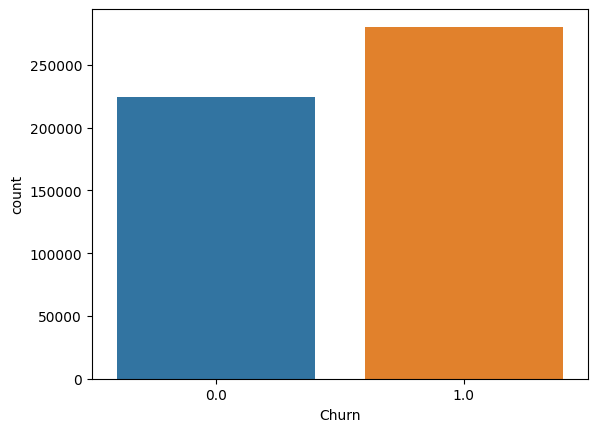

In [8]:
sns.countplot(data=df, x='Churn')
plt.show()

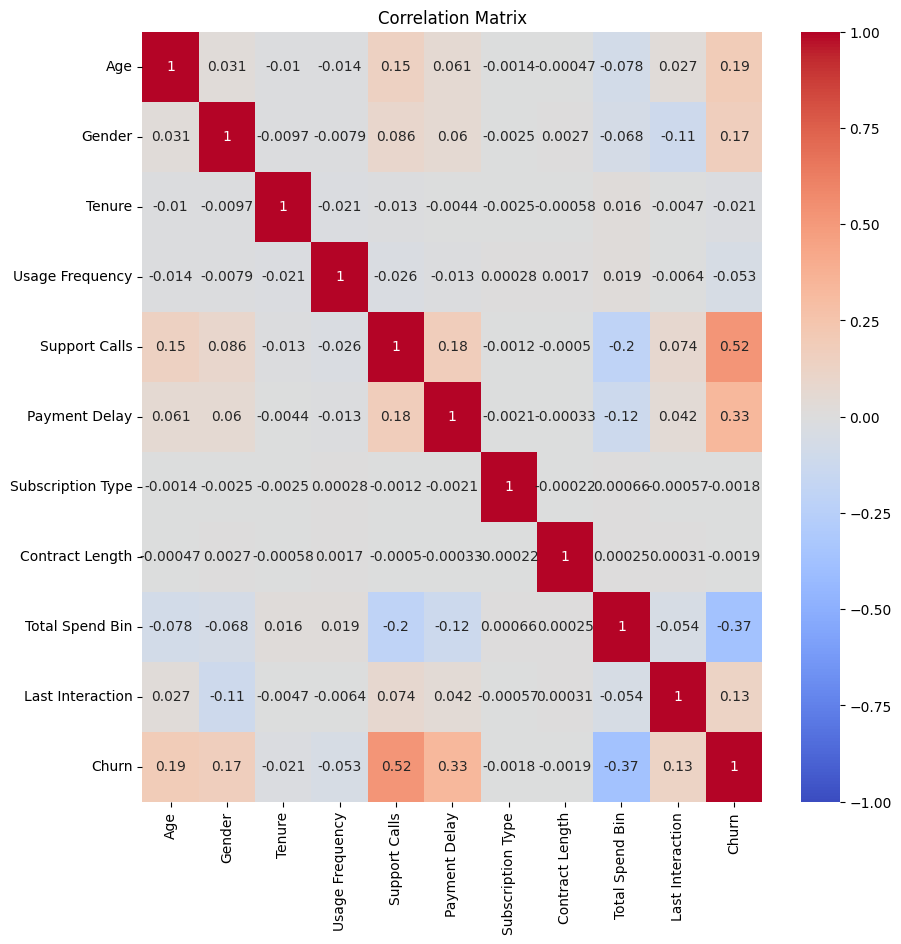

In [9]:
# Visualize - Correlation matrix
# Create a correlation matrix
corr_matrix = df.corr()
# Select the correlation values with 'default_ind'
target_corr = corr_matrix['Churn']
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

# Decision tree from scratch

### Some helper function

#### Check purity function

In [10]:
# Return True if there's only one unique class in the data, False otherwise
def CheckPurity(data):
    class_col = data[:,-1]
    unique_class = np.unique(class_col)
    if len(unique_class) == 1:
        return True
    return False

#### Classify function

In [11]:
# Return the most frequent class in the dataset
def Classify(data):
    class_col = data[:,-1]
    unique_class, count_class = np.unique(class_col, return_counts=True)
    major_class = np.argmax(count_class)
    return unique_class[major_class]

#### Split checking function

In [12]:
# return all possible splits for each feature
def SplitCheck(data):
    potential = {}
    _, feature_num = np.shape(data)
    for feature in range(feature_num - 1):
        potential[feature] = []
        value_list = np.unique(data[:, feature])
        # For categorical values
        if isinstance(value_list[0], str):
            for val in value_list:
                potential[feature].append(val)
        else:
            # For continuous values
            for index in range(len(value_list)):
                if index != 0:
                    current_val = value_list[index]
                    previous_val = value_list[index - 1]
                    potential[feature].append((current_val + previous_val) / 2)

    # Remove empty potential[feature] lists
    potential = {k: v for k, v in potential.items() if v}
    return potential

#### Split function

In [13]:
# Split the data into two parts based on the value of a feature
def split(data, feature, value):
    feature_list = data[:, feature]
    if isinstance(feature_list[0], str):
        data_left = data[feature_list == value]
        data_right = data[feature_list != value]
    else:
        data_left = data[feature_list <= value]
        data_right = data[feature_list > value]
    return data_left, data_right

#### Calulate entropy

In [14]:
# Calculate the entropy of a dataset
def Entropy(data):
    label_col = data[:, -1]
    _,value_count = np.unique(label_col, return_counts=True)
    ent = 0.0
    for i in value_count:
        probabilities = i / sum(value_count)
        ent += - probabilities * math.log(probabilities, 2)
    return ent
# Calculate the entropy of a split dataset
def TotalEntropy(data_left, data_right):
    total_length = len(data_left) + len(data_right)
    probabilities_left = len(data_left) / total_length
    probabilities_right = len(data_right) / total_length
    total_ent = probabilities_left * Entropy(data_left) + probabilities_right * Entropy(data_right)
    return total_ent

#### Info Gain Split

In [15]:
# split data set based on info gain
def InfoGainSplit(data, potential_split):
    IGMAX = -1.0
    split_key = -1.0
    split_val = -1.0
    ENT = Entropy(data)
    for key, value_list in potential_split.items():
        for value in value_list:
            data_left, data_right = split(data, key, value)
            IG = ENT - TotalEntropy(data_left, data_right)
            if IG >= IGMAX:
                IGMAX = IG
                split_key = key
                split_val = value
    return split_key, split_val

#### Calculate Gini index

In [16]:
# Calculate Gini index of a dataset
def Gini(data):
    label_col = data[:, -1]
    _,value_count = np.unique(label_col, return_counts=True)
    gini = 0.0
    for i in value_count:
        probabilities = i / sum(value_count)
        gini += probabilities ** 2
    return 1 - gini
# Calculate Gini index of a split
def TotalGini(data_left, data_right):
    total_length = len(data_left) + len(data_right)
    probabilities_left = len(data_left) / total_length
    probabilities_right = len(data_right) / total_length
    total_gini = probabilities_left * Gini(data_left) + probabilities_right * Gini(data_right)
    return total_gini

#### Gini index split

In [17]:
# Split data based on gini index
def GiniSplit(data, potential_split):
    GINIMIN = 9999
    split_key = -1.0
    split_val = -1.0
    for key, value_list in potential_split.items():
        for value in value_list:
            data_left, data_right = split(data, key, value)
            current_gini = TotalGini(data_left, data_right)
            if current_gini <= GINIMIN:
                GINIMIN = current_gini
                split_key = key
                split_val = value
    return split_key, split_val

#### Gain ratio split

In [18]:
# Split data based on gain ratio
def GainRatioSplit(data, potential_split):
    GAIN = -9999
    split_key = -1.0
    split_val = -1.0
    ENT = Entropy(data)
    for key, value_list in potential_split.items():
        for value in value_list:
            data_left, data_right = split(data, key, value)
            splitInfo = Entropy(data_left) + Entropy(data_right)
            IG = ENT - TotalEntropy(data_left, data_right)
            current_gain = IG / splitInfo
            if current_gain >= GAIN:
                GAIN = current_gain
                split_key = key
                split_val = value
    return split_key, split_val

#### Tree induction

In [19]:
# Build decision tree
def DT(data, model, min_samples = 2, max_depth = 10, counter = 0):
    # base case
    if (CheckPurity(data)) or (len(data) < min_samples) or (counter == max_depth):
        return Classify(data)
    else:
        counter+=1
        potential_split = SplitCheck(data)
        if not potential_split:
            return Classify(data)
        else:
            if model == "Info Gain":
                split_key, split_value = InfoGainSplit(data, potential_split)
            if model == "Gini":
                split_key, split_value = GiniSplit(data, potential_split)
            if model == "Gain Ratio":
                split_key, split_value = GainRatioSplit(data, potential_split)   
            data_left, data_right = split(data, split_key, split_value)
            if len(data_left) == 0 or len(data_right) == 0:
                return Classify(data)
            question = "{} <= {}".format(split_key, split_value)
            subtree = {question:[]}
            yes_ans = DT(data_left, model, min_samples, max_depth, counter)
            no_ans = DT(data_right, model, min_samples, max_depth, counter)

            if yes_ans == no_ans:
                subtree = yes_ans
            else:
                subtree[question].append(yes_ans)
                subtree[question].append(no_ans)
    return subtree

#### Classification data

In [20]:
# Check if a feature is categorical or continuous
def is_numeric_string(variable):
    if "." in variable:
        return variable.replace(".", "").isdigit()
    return variable.isdigit()
# Prediction
def Classification_data(entry, tree):
    questions = list(tree.keys())[0]
    feature, compare_opr, value = questions.split()
    # Categorical
    if not is_numeric_string(value):
        if entry[int(feature)] == value:
            answer = tree[questions][0]
        else:
            answer = tree[questions][1]
    # Continuous
    else:
        if float(entry[int(feature)]) <= float(value):
            answer = tree[questions][0]
        else:
            answer = tree[questions][1]
    # base case
    if not isinstance(answer, dict):
        return answer
    else:
        return Classification_data(entry, answer)

# Benchmark

In [21]:
# Calculate the accuracy of the tree model
def calculate_accuracy(df, tree):
    df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    df["classification"] = df.apply(Classification_data, axis=1, args=(tree,))
    df["classification_correct"] = df["classification"] == df["Churn"]
    accuracy = df["classification_correct"].mean()
    return accuracy

#### Construct DT
- Search max_depth from range (5, 12)
- Choose max_depth with highest accuracy

In [22]:
tree = DT(train_df.values, 'Info Gain', max_depth=11)

In [23]:
tree1 = DT(train_df.values, 'Gini', max_depth=10)

In [24]:
tree2 = DT(train_df.values, 'Gain Ratio', max_depth=11)

C:\Users\HP\AppData\Local\Temp\ipykernel_12228\3125655241.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  current_gain = IG / splitInfo


In [25]:
accuracy = calculate_accuracy(test_df, tree)
accuracy1 = calculate_accuracy(test_df, tree1)
accuracy2 = calculate_accuracy(test_df, tree2)
print("Accuracy of DT - InfoGain: ", accuracy)
print("Accuracy of DT - Gini: ", accuracy1)
print("Accuracy of DT - GainRatio: ", accuracy2)

Accuracy of DT - InfoGain:  0.9335127966588151
Accuracy of DT - Gini:  0.9328002216899903
Accuracy of DT - GainRatio:  0.9341560935056709


# Ensemble method


In [26]:
# Ensemble classifier
def ensemble(entry, tree1, tree2, tree3):
    answer = []
    answer.append(Classification_data(entry, tree1))
    answer.append(Classification_data(entry, tree2))
    answer.append(Classification_data(entry, tree3))
    frequency = {}
    max_frequency = 0
    most_frequent_element = None
    for element in answer:
        # Update the frequency count for the element
        if element in frequency:
            frequency[element] += 1
        else:
            frequency[element] = 1
        # Update the most frequent element if necessary
        if frequency[element] > max_frequency:
            max_frequency = frequency[element]
            most_frequent_element = element
    return most_frequent_element

In [27]:
def calculate_accuracy_ensemble(df, tree1, tree2, tree3):
    df = df.copy()  # Create a copy of the DataFrame to avoid modifying the original
    df["classification"] = df.apply(ensemble, axis=1, args=(tree1, tree2, tree3))
    df["classification_correct"] = df["classification"] == df["Churn"]
    accuracy = df["classification_correct"].mean()
    return accuracy

In [28]:
tot_accuracy = calculate_accuracy_ensemble(test_df, tree, tree1, tree2)
tot_accuracy

0.9340076403871658

# Conclusion

- Decision Tree Accuracy:
The accuracy scores of the individual decision tree models are as follows:

- DT - InfoGain: 0.9335
- DT - Gini: 0.9328
- DT - GainRatio: 0.9342

- Ensemble classifier Accuracy: 0.9340

- Decision Tree Performance:
The decision tree models built using different attribute selection measures (InfoGain, Gini, GainRatio) show comparable accuracy scores. The differences in accuracy between the three decision trees are relatively small, indicating that all three measures perform well on this dataset.

- Ensemble classifier Performance:
The Ensemble classifier's accuracy falls between the accuracy scores of the individual DTs. This suggests that the classifier is effectively utilizing the diversity of decisions made by the different DTs to produce a well-rounded prediction.